In [10]:

from google.colab import drive
import os
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


drive.mount('/content/drive', force_remount=True)


train_path = "/content/drive/MyDrive/dataset/Train"
test_path  = "/content/drive/MyDrive/dataset/Test"
denominations = ['10', '20', '50', '100', '200', '500', '2000']




Mounted at /content/drive


In [11]:

def extract_features(image_path, use_lbp=True):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv2.resize(img, (256, 256))


    hog_feats, _ = hog(img,
                       orientations=9,
                       pixels_per_cell=(16,16),
                       cells_per_block=(2,2),
                       block_norm='L2-Hys',
                       visualize=True)

    if use_lbp:

        lbp = local_binary_pattern(img, P=8, R=1, method='uniform')
        (hist, _) = np.histogram(lbp.ravel(),
                                 bins=np.arange(0, 10),
                                 range=(0, 9))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        features = np.concatenate([hog_feats, hist])
    else:
        features = hog_feats
    return features



In [12]:

X_all, y_all = [], []
for denom in denominations:
    for cls in ['real','fake']:
        folder = os.path.join(train_path, denom, cls)
        if not os.path.exists(folder):
            continue
        for file in os.listdir(folder):
            if not file.lower().endswith(('.jpg','.jpeg','.png')):
                continue
            img_path = os.path.join(folder, file)
            feats = extract_features(img_path)
            if feats is not None:
                X_all.append(feats)
                y_all.append(0 if cls=='real' else 1)
X_all = np.array(X_all)
y_all = np.array(y_all)
print("Total labeled samples:", len(X_all))



Total labeled samples: 153


In [13]:

X_train, X_eval, y_train, y_eval = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all)
print("Training samples:", len(X_train))
print("Evaluation samples:", len(X_eval))


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_eval_scaled = scaler.transform(X_eval)

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {classes[i]: class_weights[i] for i in range(len(classes))}
print("Class weights:", class_weight_dict)



Training samples: 122
Evaluation samples: 31
Class weights: {np.int64(0): np.float64(0.8840579710144928), np.int64(1): np.float64(1.150943396226415)}


In [14]:

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}
grid_search = GridSearchCV(SVC(class_weight=class_weight_dict), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

y_pred_eval = best_model.predict(X_eval_scaled)
overall_acc = accuracy_score(y_eval, y_pred_eval)
print("Overall Accuracy on evaluation set:", overall_acc)



Best parameters: {'C': 1, 'kernel': 'rbf'}
Overall Accuracy on evaluation set: 0.5806451612903226


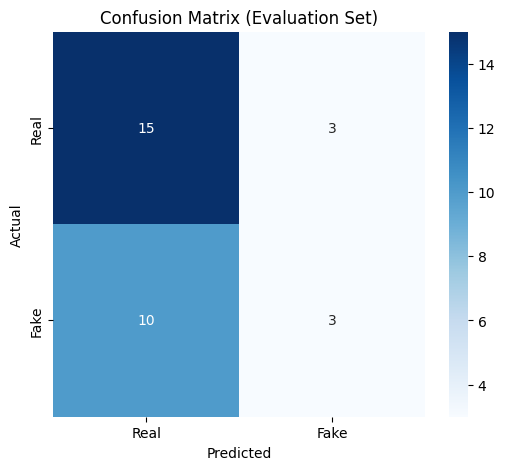

Classification Report:

              precision    recall  f1-score   support

        Real       0.60      0.83      0.70        18
        Fake       0.50      0.23      0.32        13

    accuracy                           0.58        31
   macro avg       0.55      0.53      0.51        31
weighted avg       0.56      0.58      0.54        31



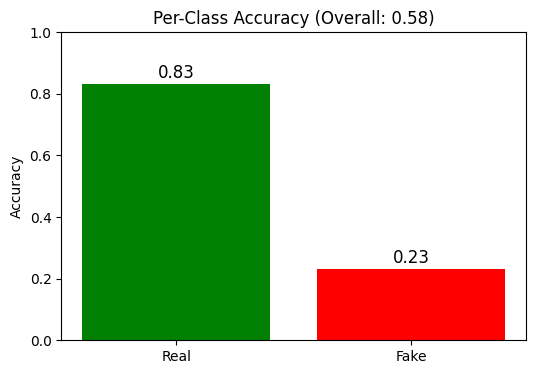

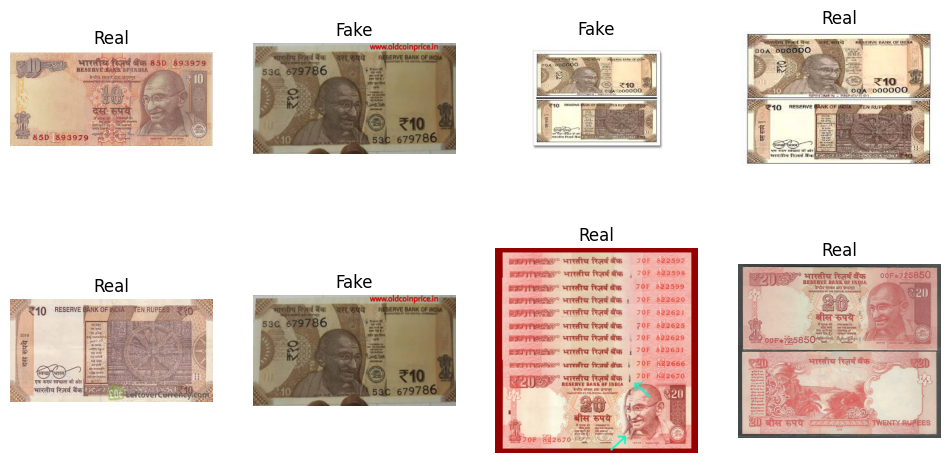

In [15]:

cm = confusion_matrix(y_eval, y_pred_eval)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real","Fake"], yticklabels=["Real","Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Evaluation Set)")
plt.show()

print("Classification Report:\n")
print(classification_report(y_eval, y_pred_eval, target_names=["Real","Fake"]))


accuracy_real = cm[0,0] / cm[0].sum() if cm[0].sum() else 0
accuracy_fake = cm[1,1] / cm[1].sum() if cm[1].sum() else 0
plt.figure(figsize=(6,4))
plt.bar(["Real","Fake"], [accuracy_real, accuracy_fake], color=['green','red'])
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title(f"Per-Class Accuracy (Overall: {overall_acc:.2f})")
for i, v in enumerate([accuracy_real, accuracy_fake]):
    plt.text(i, v+0.02, f"{v:.2f}", ha='center', fontsize=12)
plt.show()


X_test, img_paths = [], []
for denom in denominations:
    folder = os.path.join(test_path, denom)
    if not os.path.exists(folder):
        continue
    for file in os.listdir(folder):
        if not file.lower().endswith(('.jpg','.jpeg','.png')):
            continue
        img_path = os.path.join(folder, file)
        feats = extract_features(img_path)
        if feats is not None:
            X_test.append(feats)
            img_paths.append(img_path)
X_test = np.array(X_test)

if len(X_test) > 0:
    X_test_scaled = scaler.transform(X_test)
    y_pred_test = best_model.predict(X_test_scaled)

    plt.figure(figsize=(12,6))
    for i in range(min(8, len(img_paths))):
        img = cv2.imread(img_paths[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2,4,i+1)
        plt.imshow(img)
        plt.title("Real" if y_pred_test[i]==0 else "Fake")
        plt.axis('off')
    plt.show()